In [1]:
# import libraries

import pandas as pd # data frames
import numpy as np # numerical calculations
import seaborn as sns # statistical visualization
import matplotlib.pyplot as plt # seaborn is built off of matplotlib
from sklearn.linear_model import LinearRegression # model instantiation
from sklearn.preprocessing import PolynomialFeatures # polynomial transformation
from sklearn import metrics # evaluation
import itertools # for combinations
import time # code run time

In [2]:
# get built in data set 

from sklearn.datasets import load_boston
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = boston.target

In [3]:
# review built-in description

print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
# review top columns and sample records

boston_df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
# function returns statistics using .describe(), data types, null count, target correlation and multicollinearity 
# arguments are dataframe, list of features, target name 

def summary_stats(dataframe, features, target):

    explore_df = dataframe.describe().transpose() # main table to which will merge on features

    dtypes_df = pd.DataFrame(dataframe.dtypes).rename(columns={0:'dtype'})

    isnull_df = pd.DataFrame(dataframe.isnull().sum()).rename(columns={0:'nulls'})

    target_corr_df = pd.DataFrame( dataframe[ dataframe.columns[:] ].corr()[target]).rename(columns={'MEDV':'target R2'}) 

    # feature multicollinearity; the top n features will be merged with (limited by) the n records of the main dataframe
    multi_coll_df = pd.DataFrame(columns='index feature R2'.split())
    for feature in features:
        df_corr = pd.DataFrame( dataframe[ dataframe.columns[:] ].corr()[feature] ).reset_index()
        df_corr.rename(columns={feature:'R2'}, inplace=True) 
        df_corr.insert(1, 'feature', feature) 
        multi_coll_df = pd.concat([df_corr, multi_coll_df], ignore_index=True)
    multi_coll_df['ABS'] = np.abs(multi_coll_df['R2']) 
    multi_coll_df.drop(multi_coll_df[multi_coll_df['ABS'] == 1].index, inplace=True) # drop self-correlated features
    multi_coll_df.sort_values(by='ABS', ascending=False, inplace=True)
    multi_coll_df.drop(multi_coll_df[multi_coll_df['ABS'] == 1].index, inplace=True)
    multi_coll_df.drop(multi_coll_df.iloc[1::2, :].index, inplace=True) # drop every second result, i.e. duplicates
    multi_coll_df.insert(0, 'feature pairs', multi_coll_df['index'] + '_' + multi_coll_df['feature'])
    multi_coll_df.drop(['index', 'feature', 'ABS'], axis=1, inplace=True)
    multi_coll_df.rename(columns={'R2':'feature R2'}, inplace=True)
    multi_coll_df.reset_index(drop=True, inplace=True)

    # merge tables
    explore_df = explore_df.merge(dtypes_df, how='left', right_index=True, left_index=True)
    explore_df = explore_df.merge(isnull_df, how='left', right_index=True, left_index=True)
    explore_df = explore_df.merge(target_corr_df, how='left', right_index=True, left_index=True)
    explore_df = explore_df[['dtype','count','nulls','std','min','25%','50%','75%','max','target R2']] # reorder columns 
    explore_df.reset_index(inplace=True)
    explore_df.rename(columns={'index':'feature'},inplace=True) 
    explore_df = explore_df.merge(multi_coll_df, how='left', right_index=True, left_index=True).fillna('')
    
    return explore_df.style.set_properties(**{'border-left': '1.3px solid black'},subset=['feature pairs']).set_precision(2)  

In [6]:
# display summary statistics

print('\033[38;5;18m\033[1m' + '                                         SUMMARY STATISTICS') # colour then bold text
print('\n')
print('\033[38;5;18m\033[1m' + '               Data Type, Nulls, Distribution, Target Correlation            Multicollinearity') # colour then bold text
summary_stats(boston_df, boston.feature_names, 'MEDV')

                                         SUMMARY STATISTICS


               Data Type, Nulls, Distribution, Target Correlation            Multicollinearity


,feature,dtype,count,nulls,std,min,25%,50%,75%,max,target R2,feature pairs,feature R2
0,CRIM,float64,506.00,0,8.60,0.01,0.08,0.26,3.68,88.98,-0.39,TAX_RAD,0.91
1,ZN,float64,506.00,0,23.32,0.00,0.00,0.00,12.50,100.00,0.36,NOX_DIS,-0.77
2,INDUS,float64,506.00,0,6.86,0.46,5.19,9.69,18.10,27.74,-0.48,INDUS_NOX,0.76
3,CHAS,float64,506.00,0,0.25,0.00,0.00,0.00,0.00,1.00,0.18,DIS_AGE,-0.75
4,NOX,float64,506.00,0,0.12,0.39,0.45,0.54,0.62,0.87,-0.43,MEDV_LSTAT,-0.74
5,RM,float64,506.00,0,0.70,3.56,5.89,6.21,6.62,8.78,0.70,AGE_NOX,0.73
6,AGE,float64,506.00,0,28.15,2.90,45.02,77.50,94.07,100.00,-0.38,INDUS_TAX,0.72
7,DIS,float64,506.00,0,2.11,1.13,2.10,3.21,5.19,12.13,0.25,INDUS_DIS,-0.71
8,RAD,float64,506.00,0,8.71,1.00,4.00,5.00,24.00,24.00,-0.38,TAX_NOX,0.67
9,TAX,float64,506.00,0,168.54,187.00,279.00,330.00,666.00,711.00,-0.47,ZN_DIS,0.66


                             CORRELATION MATRIX


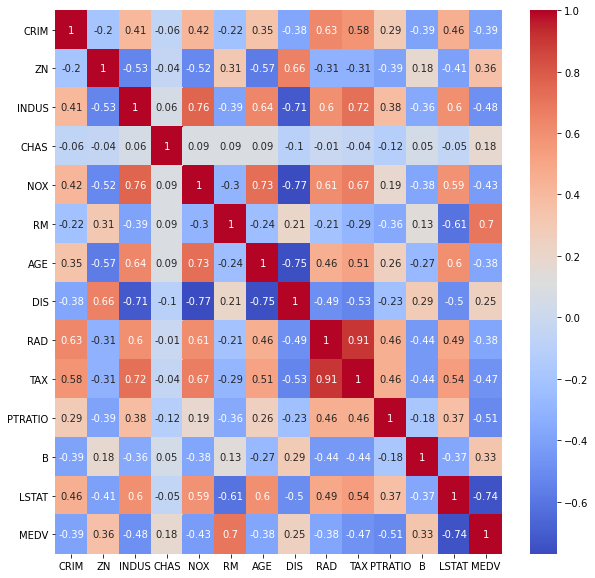

In [7]:
# correlation as matrix for comparison to statistics summary table

print('\033[38;5;18m\033[1m' + '                             CORRELATION MATRIX'+ '\033[0m') 

fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(boston_df.corr().round(2),cmap='coolwarm',annot=True)
plt.show()

In [8]:
def feature_select(dataframe, features, feature_subset, target, poly_transform, degrees, trials, test_split):
    """
    Returns: 
    Dataframe of all model experiment results
    
    Parameters:
    arg1 (dataframe): not compatible with time series data
    arg2 (list): feature column names as a list of strings (or list of list depending on agr3 inputs)
    arg3 (int): choice 1 (create subset) or 2 (do not subset) or 3 (use predetermined subset)
    arg4 (str): target colum name as a string
    arg5 (int): choice 1 (yes) or 2 (no) or 3 (both) to add polynomial transformed (including interaction) features 
    arg6 (int): polynomial transformation degrees of freedom; recommend 2 only
    arg7 (int): number of trials; test data is randomized each trial 
    arg8 (float): portion of records for testing (multiplied to total, rounded whole number);  recommended 0.3

   """
    
    # create dataframe and column headers to store results
    all_results_df = pd.DataFrame(columns='MAE MSE RMSE MAPE RMSPE R2 Trials Features Model'.split())
    
    # features either subset or not
    features_combos  = []
    if feature_subset == 1: # feature subsets, i.e. 2^n - 1 
        for i in range(0, len(features) + 1):  # to get all lengths
             for subset in itertools.combinations(features, i):
                    if len(subset) == 0:
                        pass
                    else:
                        features_combos.append(list(subset)) # create list of more than one list
    elif feature_subset == 2:
        features_combos.append(list(features)) # list of a single list
    else:
        features_combos = features # use predetermined list of more than one list 
    
    # list of settings based whether or not polynomial transformation
    if poly_transform == 1:
        poly_settings = [1] # only poly features
    elif poly_transform == 2:
        poly_settings = [0] # only original features
    else:
        poly_settings = [1,0] # include both poly and original features 
    
    # run experiment for n trials, each polynomial setting and feature subsets 
    for ftr_list in features_combos:
        for poly_setting in poly_settings:
            for trial in range(0,trials):

                # reload data
                model_df = dataframe

                # randomize then split directly on data frame rather than using sklearn train_test_split 
                # in order to easily refer back to original data set for if required
                model_df = model_df.sample(frac=1) 

                # retain original index
                model_df = model_df.reset_index()
                model_df = model_df.rename(columns={'index':'IDX'})

                # split data 
                train_data = model_df.iloc[ : len(model_df) - round(len(model_df) * test_split) ]
                test_data = model_df.iloc[ len(model_df) - round(len(model_df) * test_split) : ]

                # get features and target
                x_train = train_data[ftr_list]
                x_test = test_data[ftr_list]
                y_train = train_data[target]
                y_test = test_data[target]

                # polynomialize features if applicable
                if poly_setting == 1:
                    poly_features = PolynomialFeatures(degree=degrees)
                    x_train = poly_features.fit_transform(x_train)
                    x_test = poly_features.fit_transform(x_test)
                else:
                    pass

                # create, train and predict
                lm = LinearRegression()
                lm.fit(x_train, y_train)
                predictions = lm.predict(x_test)

                # evaluate the model
                # note test results differ for each execution of previous cell due to randomization

                # new data frame for model
                model_results_df = pd.DataFrame(columns='MAE MSE RMSE MAPE RMSPE R2 Trials Features Model'.split())
                columns = model_results_df.columns.to_list() # data frame columns for dictionary 
                data = [] # list to store dictionary

                # list of results
                values = [round(metrics.mean_absolute_error(y_test, predictions),4), # mae
                          round(metrics.mean_squared_error(y_test, predictions),4), # mse
                          round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),4), # rmse
                          round((metrics.mean_absolute_error(y_test, predictions) / np.mean(y_test))*100,2), # mape
                          round((np.sqrt(metrics.mean_squared_error(y_test, predictions)) / np.mean(y_test))*100,2), # rmspe
                          round(metrics.explained_variance_score(y_test, predictions),4), # r2
                          trials, 
                          len(ftr_list), # features 
                          str(poly_setting) + "_" + "_".join(str(x) for x in ftr_list)] # model

                # store the created dictionary as list    
                zipped = zip(columns, values)
                a_dictionary = dict(zipped)
                data.append(a_dictionary) 

                # add results to data frame
                all_results_df = all_results_df.append(data, ignore_index=True)
        
    return all_results_df

In [9]:
def create_subset(seriesfromdataframe):
    """
    Returns: 
    List of list of features for input back into feature_select() function in order to run multiple trials
    
    Parameters:
    arg1 (series form dataframe)

    """
    subsets = []
    for x in seriesfromdataframe.to_list():
        subsets.append(list(x.split("_")[1:]))
    return subsets

In [10]:
# execute experiments for all models (1 trial) using function and display top 25 model results

# colour, bold, unapply
print('\033[38;5;18m\033[1m' + '                                             SUMMARY RESULTS'+ '\033[0m') 
print('\n')

# get start time of code execution
start_time = time.time()

# input function arguments and run
all_results_df = feature_select(boston_df, boston.feature_names, 1, 'MEDV', 3, 2, 1, 0.3)
# see docstrings: dataframe, features, feature_subset, target, poly_transform, degrees, trials, test_split

# show number of experiments and run time 
print( 'Total experiments: ' + str( '{:,}'.format(len(all_results_df)) ) )

# convert end time to minutes, string and split on decimal to display minutes and seconds separately
end_time = time.time() - start_time
minutes = str(end_time/60).split('.')[0]
seconds  = str( int(str(end_time/60).split('.')[1][:2]) / 100  * 60 ).split('.')[0] 
print( 'Run time: ' + minutes + ' minutes ' + seconds + ' seconds')

# cast trial_count and features objects as integers
all_results_df['Trials'] = all_results_df['Trials'].astype(int)
all_results_df['Features'] = all_results_df['Features'].astype(int)

# average results and display
all_avg_results = all_results_df.groupby('Model').mean().sort_values('RMSE',ascending=True)
all_avg_results = all_avg_results.reset_index() # flatten
all_avg_results.head(25)

                                             SUMMARY RESULTS


Total experiments: 16,382
Run time: 5 minutes 34 seconds


,Model,MAE,MSE,RMSE,MAPE,RMSPE,R2,Trials,Features
0,1_ZN_RM_AGE_DIS_RAD_TAX_PTRATIO_B_LSTAT,2.1986,7.8719,2.8057,9.93,12.67,0.8931,1,9
1,1_CRIM_ZN_CHAS_RM_AGE_RAD_TAX_PTRATIO_LSTAT,2.2626,8.3774,2.8944,10.25,13.12,0.8953,1,9
2,1_ZN_INDUS_RM_RAD_PTRATIO_LSTAT,2.2711,8.3936,2.8972,10.30,13.14,0.8796,1,6
3,1_CRIM_ZN_RM_DIS_B_LSTAT,2.3323,8.7997,2.9664,10.54,13.41,0.9007,1,6
4,1_CRIM_CHAS_NOX_RM_AGE_DIS_TAX_PTRATIO_LSTAT,2.1112,8.8577,2.9762,9.55,13.46,0.8885,1,9
5,1_ZN_INDUS_CHAS_RM_DIS_TAX_PTRATIO_LSTAT,2.1432,8.8808,2.9801,9.39,13.06,0.9084,1,8
6,1_CRIM_ZN_INDUS_NOX_RM_PTRATIO,2.3907,8.9353,2.9892,10.80,13.51,0.8551,1,6
7,1_CRIM_ZN_CHAS_RM_AGE_DIS_TAX_PTRATIO_B_LSTAT,2.1625,9.0149,3.0025,10.21,14.17,0.8306,1,10
8,1_CRIM_ZN_INDUS_RM_DIS_RAD_PTRATIO_LSTAT,2.3041,9.0450,3.0075,10.61,13.85,0.8803,1,8
9,1_CRIM_ZN_INDUS_RM_AGE_DIS_RAD_TAX_PTRATIO_LSTAT,2.1492,9.1323,3.0220,9.96,14.00,0.8718,1,10


In [11]:
# display top 25 non-polynomial transformed model results

# colour, bold, unapply
print('\033[38;5;18m\033[1m' + '                                             SUMMARY RESULTS'+ '\033[0m') 
print('\n')

print('Top 25 non-polynomial transformed models') 

all_avg_results[all_avg_results['Model'].str.contains('0') ].head(25)

                                             SUMMARY RESULTS


Top 25 non-polynomial transformed models


,Model,MAE,MSE,RMSE,MAPE,RMSPE,R2,Trials,Features
462,0_CHAS_NOX_RM_RAD_TAX_PTRATIO_LSTAT,3.0353,14.4126,3.7964,14.07,17.60,0.7792,1,7
582,0_ZN_INDUS_CHAS_RM_DIS_RAD_TAX_PTRATIO_B_LSTAT,2.9358,15.1828,3.8965,13.68,18.16,0.7849,1,10
585,0_CRIM_ZN_CHAS_RM_RAD_TAX_PTRATIO_B,2.9669,15.1945,3.8980,13.59,17.85,0.7840,1,8
610,0_CRIM_ZN_NOX_RM_DIS_RAD_TAX_PTRATIO_B_LSTAT,2.8682,15.2516,3.9053,12.54,17.07,0.8088,1,10
617,0_CRIM_ZN_CHAS_NOX_RM_RAD_PTRATIO_B_LSTAT,3.1185,15.2943,3.9108,14.66,18.38,0.7696,1,9
622,0_NOX_RM_AGE_DIS_RAD_TAX_PTRATIO_LSTAT,3.0637,15.3046,3.9121,14.04,17.93,0.7284,1,8
661,0_CRIM_INDUS_NOX_RM_DIS_RAD_PTRATIO_B_LSTAT,2.9945,15.4881,3.9355,14.15,18.60,0.7680,1,9
681,0_NOX_RM_DIS_RAD_TAX_PTRATIO_B,3.0579,15.5788,3.9470,13.90,17.94,0.8113,1,7
732,0_CRIM_ZN_CHAS_RM_RAD_TAX_PTRATIO_B_LSTAT,3.1749,15.7412,3.9675,14.41,18.01,0.7697,1,9
740,0_INDUS_CHAS_RM_DIS_TAX_PTRATIO_LSTAT,3.0096,15.7765,3.9720,13.74,18.14,0.7961,1,7


In [13]:
# execute 100 trials for top 25 experiments and display results

# colour, bold, unapply
print('\033[38;5;18m\033[1m' + '                                             SUMMARY RESULTS'+ '\033[0m') 
print('\n')

# get start time of code execution
start_time = time.time()

# input function arguments and run
top25_results_df = feature_select(boston_df, 
                                  create_subset(all_avg_results.head(25)['Model']),
                                  3, 'MEDV', 1, 2, 100, 0.3)
# see docstrings: dataframe, features, feature_subset, target, poly_transform, degrees, trials, test_split

# show number of experiments and run time 
print( 'Total experiments: ' + str( '{:,}'.format(len(top25_results_df)) ) )

# convert end time to minutes, string and split on decimal to display minutes and seconds separately
end_time = time.time() - start_time
minutes = str(end_time/60).split('.')[0]
seconds  = str( int(str(end_time/60).split('.')[1][:2]) / 100  * 60 ).split('.')[0] 
print( 'Run time: ' + minutes + ' minutes ' + seconds + ' seconds')

# cast trial_count and features objects as integers
top25_results_df['Trials'] = top25_results_df['Trials'].astype(int)
top25_results_df['Features'] = top25_results_df['Features'].astype(int)

# average results and display
top25_avg_results = top25_results_df.groupby('Model').mean().sort_values('RMSE',ascending=True)
top25_avg_results = top25_avg_results.reset_index() # flatten
top25_avg_results

                                             SUMMARY RESULTS


Total experiments: 2,500
Run time: 0 minutes 53 seconds


,Model,MAE,MSE,RMSE,MAPE,RMSPE,R2,Trials,Features
0,1_RM_AGE_DIS_PTRATIO_LSTAT,2.684852,15.189671,3.878475,11.9425,17.2512,0.820762,100,5
1,1_RM_AGE_B_LSTAT,3.016788,19.543110,4.393392,13.4384,19.5617,0.767790,100,4
2,1_CRIM_ZN_CHAS_NOX_RM_DIS_RAD_TAX_LSTAT,3.013736,21.262958,4.427548,13.3758,19.6537,0.746009,100,9
3,1_ZN_INDUS_RM_RAD_PTRATIO_LSTAT,3.086896,22.253762,4.443955,13.7243,19.7558,0.733289,100,6
4,1_CHAS_NOX_RM_AGE_RAD_TAX_PTRATIO_LSTAT,3.129047,23.104542,4.474865,13.9617,19.9550,0.722318,100,8
5,1_CRIM_ZN_INDUS_RM_AGE_DIS_RAD_TAX_PTRATIO_LSTAT,3.132123,22.469764,4.521112,13.8669,20.0241,0.736083,100,10
6,1_CRIM_CHAS_NOX_RM_AGE_DIS_TAX_PTRATIO_LSTAT,3.101916,24.051963,4.566194,13.7835,20.2870,0.712408,100,9
7,1_ZN_RM_AGE_DIS_RAD_TAX_PTRATIO_B_LSTAT,3.230478,24.511906,4.693969,14.3554,20.8626,0.708491,100,9
8,1_CRIM_CHAS_NOX_RM_AGE_DIS_RAD_TAX_PTRATIO_B_L...,3.200810,25.286087,4.773925,14.1624,21.1300,0.699569,100,11
9,1_ZN_INDUS_CHAS_RM_DIS_TAX_PTRATIO_LSTAT,3.282747,26.191889,4.779802,14.5716,21.2086,0.688853,100,8


In [14]:
# execute 100 trials for top performing model 

# colour, bold, unapply
print('\033[38;5;18m\033[1m' + '                                             SUMMARY RESULTS'+ '\033[0m') 
print('\n')

# get start time of code execution
start_time = time.time()

# input function arguments and run
best_model_results_df = feature_select(boston_df, ['RM','DIS','TAX','PTRATIO','LSTAT'], 2, 'MEDV', 1, 2, 100, 0.3)
# see docstrings: dataframe, features, feature_subset, target, poly_transform, degrees, trials, test_split

# show number of experiments and run time 
print( 'Total experiments: ' + str( '{:,}'.format(len(best_model_results_df)) ) )

# convert end time to minutes, string and split on decimal to display minutes and seconds separately
end_time = time.time() - start_time
minutes = str(end_time/60).split('.')[0]
seconds  = str( int(str(end_time/60).split('.')[1][:2]) / 100  * 60 ).split('.')[0] 
print( 'Run time: ' + minutes + ' minutes ' + seconds + ' seconds')

# cast trial_count and features objects as integers
best_model_results_df['Trials'] = best_model_results_df['Trials'].astype(int)
best_model_results_df['Features'] = best_model_results_df['Features'].astype(int)

# display
best_model_results_descr_df = best_model_results_df.describe()
best_model_results_descr_df.loc[['mean']].round(2)

                                             SUMMARY RESULTS


Total experiments: 100
Run time: 0 minutes 1 seconds


,MAE,MSE,RMSE,MAPE,RMSPE,R2,Trials,Features
mean,2.57,14.31,3.76,11.36,16.63,0.83,100.0,5.0


In [15]:
# evaluate best performing model

# parameters
model_df = boston_df # reload data
features = ['RM','DIS','TAX','PTRATIO','LSTAT'] # list of feature names
target = 'MEDV'
testsplit = 0.3
poly_setting = 1 # polnomial transformation (Yes = 1, No = 0)

# randomize then split directly on data frame rather than using sklearn train_test_split 
# in order to easily refer back to original data set for if required
model_df = model_df.sample(frac=1) 

# retain original index
model_df = model_df.reset_index()
model_df = model_df.rename(columns={'index':'IDX'})

# split data 
train_data = model_df.iloc[ : len(model_df) - round(len(model_df) * testsplit) ]
test_data = model_df.iloc[ len(model_df) - round(len(model_df) * testsplit) : ]

# get features and target
x_train = train_data[features]
x_test = test_data[features]
y_train = train_data[target]
y_test = test_data[target]

# polynomialize features
if poly_setting == 1:
    poly_features = PolynomialFeatures(degree=2)
    x_train = poly_features.fit_transform(x_train)
    x_test = poly_features.fit_transform(x_test)
else:
    pass

# create, train and predict
lm = LinearRegression()
lm.fit(x_train, y_train)
predictions = lm.predict(x_test)

In [17]:
# predictions, actuals and predictors

model_output_df = pd.DataFrame(x_test)
model_output_df.columns = poly_features.get_feature_names()
model_output_df.insert(0, 'IDX', test_data['IDX'].to_list(), allow_duplicates=True) # can insert array
model_output_df.insert(1, 'Predictions', predictions, allow_duplicates=True) # can insert array
model_output_df.insert(2, 'Actuals', y_test.to_list(), allow_duplicates=True) # need to convert series to list before inserting

model_output_df

,IDX,Predictions,Actuals,1,x0,x1,x2,x3,x4,x0^2,...,x1^2,x1 x2,x1 x3,x1 x4,x2^2,x2 x3,x2 x4,x3^2,x3 x4,x4^2
0,473,22.889774,29.8,1.0,6.980,2.5329,666.0,20.2,11.66,48.720400,...,6.415582,1686.9114,51.16458,29.533614,443556.0,13453.2,7765.56,408.04,235.532,135.9556
1,24,15.548842,15.6,1.0,5.924,4.3996,307.0,21.0,16.30,35.093776,...,19.356480,1350.6772,92.39160,71.713480,94249.0,6447.0,5004.10,441.00,342.300,265.6900
2,223,28.884035,30.1,1.0,6.618,3.2721,307.0,17.4,7.60,43.797924,...,10.706638,1004.5347,56.93454,24.867960,94249.0,5341.8,2333.20,302.76,132.240,57.7600
3,456,13.409893,12.7,1.0,5.976,2.5806,666.0,20.2,19.01,35.712576,...,6.659496,1718.6796,52.12812,49.057206,443556.0,13453.2,12660.66,408.04,384.002,361.3801
4,262,51.950417,48.8,1.0,8.398,2.2885,264.0,13.0,5.91,70.526404,...,5.237232,604.1640,29.75050,13.525035,69696.0,3432.0,1560.24,169.00,76.830,34.9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,421,19.341124,14.2,1.0,6.006,1.8746,666.0,20.2,15.70,36.072036,...,3.514125,1248.4836,37.86692,29.431220,443556.0,13453.2,10456.20,408.04,317.140,246.4900
148,81,25.886788,23.9,1.0,6.619,5.4007,281.0,19.0,7.22,43.811161,...,29.167560,1517.5967,102.61330,38.993054,78961.0,5339.0,2028.82,361.00,137.180,52.1284
149,147,11.042112,14.6,1.0,4.926,1.4608,403.0,14.7,29.53,24.265476,...,2.133937,588.7024,21.47376,43.137424,162409.0,5924.1,11900.59,216.09,434.091,872.0209
150,125,20.042894,21.4,1.0,5.986,1.9929,188.0,19.1,14.81,35.832196,...,3.971650,374.6652,38.06439,29.514849,35344.0,3590.8,2784.28,364.81,282.871,219.3361


In [16]:
# predictors to compare to output

test_data[ ['IDX','RM','DIS','TAX','PTRATIO','LSTAT'] ]

,IDX,RM,DIS,TAX,PTRATIO,LSTAT
354,473,6.980,2.5329,666.0,20.2,11.66
355,24,5.924,4.3996,307.0,21.0,16.30
356,223,6.618,3.2721,307.0,17.4,7.60
357,456,5.976,2.5806,666.0,20.2,19.01
358,262,8.398,2.2885,264.0,13.0,5.91
...,...,...,...,...,...,...
501,421,6.006,1.8746,666.0,20.2,15.70
502,81,6.619,5.4007,281.0,19.0,7.22
503,147,4.926,1.4608,403.0,14.7,29.53
504,125,5.986,1.9929,188.0,19.1,14.81


In [19]:
# view coefficients, sample predictors, prediction

rowidx = 473

# get test row as array
row_array = np.array(model_output_df.loc[model_output_df['IDX'] == rowidx].iloc[0, 3:])

print( 'Intercept: ' + str(lm.intercept_)  + '\n')
print( 'Coefficients: '+ str(lm.coef_) + '\n')
print( 'Predictors IDX ' + str(rowidx) + ': ' + str(row_array) + '\n')
print( 'Prediction: ' + str(lm.intercept_ + np.dot(lm.coef_,row_array)) )


Intercept: -201.54936527883999

Coefficients: [ 0.00000000e+00  3.74645195e+01 -6.69303354e+00 -8.95647344e-03
  1.25042410e+01  5.08009322e-01 -6.07005567e-01  5.90457142e-01
 -8.67946015e-03 -1.21293866e+00 -1.45432468e-01  1.53067808e-01
 -5.18309952e-03  8.04641532e-02  1.07735462e-01 -6.33077541e-06
  5.96866563e-03 -2.60015900e-03 -2.06059268e-01 -3.39009106e-02
  3.61424853e-02]

Predictors IDX 473: [1.00000000e+00 6.98000000e+00 2.53290000e+00 6.66000000e+02
 2.02000000e+01 1.16600000e+01 4.87204000e+01 1.76796420e+01
 4.64868000e+03 1.40996000e+02 8.13868000e+01 6.41558241e+00
 1.68691140e+03 5.11645800e+01 2.95336140e+01 4.43556000e+05
 1.34532000e+04 7.76556000e+03 4.08040000e+02 2.35532000e+02
 1.35955600e+02]

Prediction: 22.88977369149839


In [20]:
# best performing model results

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('MAPE: ', (metrics.mean_absolute_error(y_test, predictions) / np.mean(y_test))*100)
print('RMSPE: ', (np.sqrt(metrics.mean_squared_error(y_test, predictions)) / np.mean(y_test))*100)
print('R2:', metrics.explained_variance_score(y_test, predictions))



MAE: 2.6846364610292217
MSE 14.507518830497885
RMSE: 3.80887369579222
MAPE:  12.035532873512508
RMSPE:  17.075617217531846
R2: 0.8376848636097338


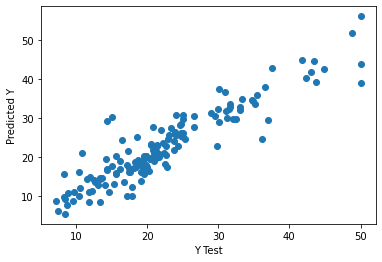

In [21]:
# scatter plot test versus predicted

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

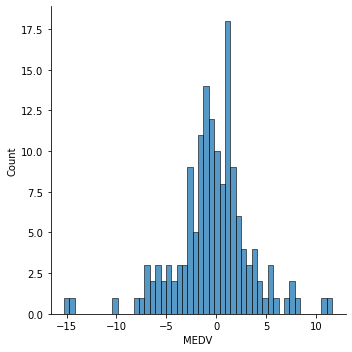

In [22]:
# residuals distribution

sns.displot((y_test-predictions),bins=50);